This notebook is devoted to the development of an easy-to-use class to handle CBC waveforms.

In [1]:
import lal, lalsimulation
import numpy as np

In [2]:
class Detector(object):
    """
    A class representing a gravitational wave detector.
    """
    
    detMap = {'H1': lal.LALDetectorIndexLHODIFF, \
              'L1': lal.LALDetectorIndexLLODIFF, \
              'G1': lal.LALDetectorIndexGEO600DIFF, \
              'V1': lal.LALDetectorIndexVIRGODIFF}
    
    def __init__(self, detector):
        # Lookup the detector from the table.
        try:
            self.detector = self.detMap[detector]
        except KeyError:
            raise ValueError("{} is not a valid detector.".format(detector))
        self.detval = lal.CachedDetectors[self.detector]
        #self.response = self.detval.response
    
    def response(self, gps, ra, dec, psi = 0):
        """
        Calculate the antenna resonse at a given sky position and polarisation
        angle.
        
        Parameters
        ----------
        time : float
            The time, in GPS seconds.
        ra : float
            The right ascension, in radians. 
        dec : float
            The declination, in radians.
        psi : float
            The polarisation angle of the gravitational wave, in radians.
            Defaults to 0.
            
        Returns
        -------
        fp : float
            The response, F+, for the + polarisation.
        fc : float
            The response, Fx, for the x polarisation.
        """
        gps = lal.LIGOTimeGPS(gps)
        gmst_rad = lal.GreenwichMeanSiderealTime(gps)
        
        fp, fc = lal.ComputeDetAMResponse(self.detval.response, ra, dec, psi, gmst_rad)
        return fp, fc
        

In [3]:
L1 = Detector("L1")

In [4]:
L1.response(1126620016, 0,0)

(0.4156634344861688, -0.09731785424408984)

In [5]:
ras = np.linspace(0,2*np.pi, 200)
decs = np.linspace(0,np.pi, 100)

mapp = np.zeros((200,100))
mapc = np.zeros((200,100))
xv, yv = np.meshgrid(ras, decs, sparse=False, indexing='ij')
for i in range(200):
    for j in range(100):
        mapp[i][j] = L1.response(1126620016, xv[i,j],yv[i,j])[0]
        mapc[i][j] = L1.response(1126620016, xv[i,j],yv[i,j])[1]

In [32]:
class CBC(object):
    """
    A class representing a Compact Binary Coalescence event in gravitational
    waves.
    
    """
    
    def __init__(self, mass1, mass2, 
                 spin1=(0,0,0), spin2=(0,0,0),
                 distance = 400,
                 inclination = 0,
                 phase = 0,
                ):
        """
        A gravitational wave CBC Event.
        
        Parameters
        ----------
        mass1 : float
            The mass, in solar masses, of the primary component.
        mass2 : float
            The mass, in solar masses, of the secondary component.
        spin1 : list
            The spin vector for the primary component.
            Defaults to (0,0,0).
        spin2 : list
            The spin vector for the secondary component.
            Defaults to (0,0,0).
        distance : float
            The luminosity distance to the event in megaparsec. 
            Defaults to 400 Mpc.
        inclination : float
            The inclination of the source. 
            Defaults to 0.
        phase : float
            The phase at which coalescence occurs.
            Defaults to 0.
        """
        self.mass1, self.mass2 = mass1*lal.MSUN_SI, mass2*lal.MSUN_SI
        self.spin1, self.spin2 = spin1, spin2
        self.distance = distance *1e6 * lal.PC_SI
        self.cophase = phase
        self.inclination = inclination
        
    def apply_response(self, detector, gps, ra, dec, psi=0, df=0.677380716732122, ):
        """
        Apply an antenna response to a waveform.
        
        Parameters
        ----------
        dt : float
            The time spacing  of the timeseries
        detector : Detector object
            The detector for which the response should be calculated.
        time : float
            The time, in GPS seconds.
        ra : float
            The right ascension, in radians. 
        dec : float
            The declination, in radians.
        psi : float
            The polarisation angle of the gravitational wave, in radians.
            Defaults to 0.
        """
        fp, fc = detector.response(gps, ra, dec, psi)
        t, hf, hc = self.freqseries(df)
        return t, hf*fp, hc*fc
        
    def intrinsic(self):
        """
        Return a dictionary of instrinsic parameters of this CBC event.
        
        Returns
        dict
            A dictionary of the parameters of the event
        """
        dictionary = {}
        dictionary['inclination'] = self.inclination
        dictionary['coalsence phase'] = self.cophase
        dictionary['mass 1'] = self.mass1
        dictionary['mass 2'] = self.mass2
        dictionary['distance'] = self.distance
        dictionary['spin 1'] = self.spin1
        dictionary['spin 2'] = self.spin2
        
        
        return dictionary
        
    def timeseries(self, dt=0.0002):
        """
        Return a time-domain representation of the CBC waveform.
        
        Parameters
        ----------
        dt : float
            The time-spacing of the timeseries. Defaults to 0.0002
            
        Returns
        -------
        times : ndarray
            An array of timestamps
        hp : ndarray
            An array of h+ amplitudes
        hx : ndarray
            An array of hx amplitudes.
        """
        
        flower = 10 
        fref = 10
        z = 0.0
        lambda1 = lambda2 = 0.0
        amporder = 0
        phorder = 0

        waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
        approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
        #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
        
        hp, hc = lalsimulation.SimInspiralTD(self.cophase, dt, 
                                self.mass1, self.mass2,
                                self.spin1[0], self.spin1[1], self.spin1[2],
                                self.spin2[0], self.spin2[1], self.spin2[2],
                                flower, fref, self.distance, z,
                                self.inclination, lambda1, lambda2,
                                waveflags, None, amporder, phorder, approximant
                                )
        
        times = np.linspace(0, len(hp.data.data)*hp.deltaT, 
                               len(hp.data.data)) + hp.epoch
        
        return times, hp.data.data, hc.data.data
    
    def freqseries(self, df=0.677380716732122):
        """
        Return a time-domain representation of the CBC waveform.
        
        Parameters
        ----------
        df : float
            The frequency-spacing of the series. Defaults to 0.01
            
        Returns
        -------
        freqs : ndarray
            An array of frequencies
        hp : ndarray
            An array of h+ amplitudes
        hx : ndarray
            An array of hx amplitudes.
        """
        
        flower = 10 
        fupper = 2000
        z = 0.0
        lambda1 = lambda2 = 0.0
        amporder = 0
        phorder = 0

        waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
        approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
        #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
        
        hp, hc = lalsimulation.SimInspiralFD(self.cophase, df, 
                                self.mass1, self.mass2,
                                self.spin1[0], self.spin1[1], self.spin1[2],
                                self.spin2[0], self.spin2[1], self.spin2[2],
                                flower, fupper, 40,  self.distance, z,
                                self.inclination, lambda1, lambda2,
                                waveflags, None, amporder, phorder, approximant
                                )
        
        freqs = np.linspace(0, len(hp.data.data)*hp.deltaF, 
                               len(hp.data.data)) + hp.f0
        
        return freqs, hp.data.data, hc.data.data

In [33]:
cbc1 = CBC(5,5)
cbc2 = CBC(5,5, phase=0.4)

In [34]:
fs = cbc1.apply_response(detector=L1, ra=0, dec=0, gps=1126620016, df=.1)

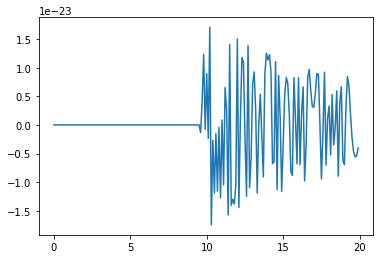

In [39]:
plt.plot(fs[0][:200], fs[1][:200])

In [ ]:
ts = cbc1.timeseries(dt = 0.0001)
ts2 = cbc2.timeseries(dt = 0.0001)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
f, ax = plt.subplots(2,1)
ax[0].plot(ts[0][-1000:], ts[1][-1000:])
ax[0].plot(ts[0][-1000:], ts[2][-1000:])
ax[1].plot(ts[0][-1000:], ts2[1][-1000:])
ax[1].plot(ts[0][-1000:], ts2[2][-1000:])